In [ ]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install qiskit[visualization]
!pip install matplotlib
token = ""#introducir el código que se obtenga en la aplicación de IBM
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
  token=token, # Your token is confidential.

  instance="" #introducir el código de la instancia,
  name="", # Introducir el tu cuenta de IBM
  set_as_default=True,
)

In [ ]:
import qiskit
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import matplotlib
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.primitives import BitArray
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

In [ ]:
# Implementación eficiente de U_f con solo un qubit auxiliar, para f(a,b,c)=or(and(a,b),and(not(a),xor(b,c)))
circ = qiskit.QuantumCircuit(5)
circ.ccx(0,1,4)
circ.cx(1,2)
circ.x(0)
circ.ccx(0,2,3)
circ.cx(4,3)
circ.x(0)
circ.cx(1,2)
circ.ccx(0,1,4)


gatef = circ.to_gate(label='U_f')

# Algoritmo de Deutsch-Jozsa aplicado a U_f
djf = qiskit.QuantumCircuit(5,3)
#qc.reset()
djf.x(3)
djf.barrier()
djf.h(0)
djf.h(1)
djf.h(2)
djf.h(3)
djf.barrier()
djf.append(gatef, [0,1,2,3,4], [])
djf.barrier()
djf.h(0)
djf.h(1)
djf.h(2)
djf.barrier()
djf.measure([0,1,2], [0,1,2])
isa_circuitf = pm.run(djf)

In [ ]:
# Implementación de U_g para g(a,b,c)=not(xor(and(a,b),c))
circ2 = qiskit.QuantumCircuit(4)
circ2.ccx(0,1,3)
circ2.cx(2,3)
circ2.x(3)



gateg = circ2.to_gate(label='U_g')
# Algoritmo de Deutsch-Jozsa para U_g
djg = qiskit.QuantumCircuit(4,3)

djg.x(3)
djg.barrier()
djg.h(0)
djg.h(1)
djg.h(2)
djg.h(3)
djg.barrier()
djg.append(gateg, [0,1,2,3], [])
djg.barrier()
djg.h(0)
djg.h(1)
djg.h(2)
djg.barrier()
djg.measure([0,1,2], [0,1,2])
isa_circuitg = pm.run(djg)

In [ ]:
# Implementación de U_h, donde h(a,b,c)=not(xor(a,not(b)))
circ3 = qiskit.QuantumCircuit(4)
circ3.cx(0,3)
circ3.x(1)
circ3.cx(1,3)
circ3.x(1)
circ3.x(3)



gateh = circ3.to_gate(label='U_h')

# Algoritmo de Deutsch-Jozsa para U_h
djh = qiskit.QuantumCircuit(4,3)

djh.x(3)
djh.barrier()
djh.h(0)
djh.h(1)
djh.h(2)
djh.h(3)
djh.barrier()
djh.append(gateh, [0,1,2,3], [])
djh.barrier()
djh.h(0)
djh.h(1)
djh.h(2)
djh.barrier()
djh.measure([0,1,2], [0,1,2])
isa_circuith = pm.run(djh)


In [ ]:
#f4(a,b,c) =xor( xor( and(a,b), and(a,c) ),and(b,c) )



# --- Oracle para f4(a,b,c) = (a∧b) xor (a∧c) xor (b∧c) ---

# Asignación de qubits:
#  q0 = a, q1 = b, q2 = c
#  q3 = T₁ = a∧b
#  q4 = T₂ = a∧c
#  q5 = T₃ = b∧c
#  q6 = ancilla de salida que acumula T₁⊕T₂⊕T₃

circ_f4 = QuantumCircuit(7)

# 1) T₁ = a ∧ b → q3
circ_f4.ccx(0, 1, 3)

# 2) T₂ = a ∧ c → q4
circ_f4.ccx(0, 2, 4)

# 3) T₃ = b ∧ c → q5
circ_f4.ccx(1, 2, 5)

# 4) Acumular T₁⊕T₂⊕T₃ en q6
circ_f4.cx(3, 6)   # q6 ⊕= T₁
circ_f4.cx(4, 6)   # q6 ⊕= T₂
circ_f4.cx(5, 6)   # q6 ⊕= T₃

# 5) “Uncompute” de los temporales q3, q4, q5
circ_f4.ccx(1, 2, 5)  # limpia q5 (b∧c)
circ_f4.ccx(0, 2, 4)  # limpia q4 (a∧c)
circ_f4.ccx(0, 1, 3)  # limpia q3 (a∧b)

# Convertimos a puerta etiquetada
gate_f4 = circ_f4.to_gate(label='U_f4')

# --- Circuito Deutsch–Jozsa completo sobre 3 inputs + 4 ancillas ---

# 7 qubits totales: q0..q2 = entradas; q3,q4,q5 = temporales; q6 = ancilla de salida
djf4 = QuantumCircuit(7, 3)

# 1) Preparo la ancilla de salida q6 en |−> (X + H)
djf4.x(6)
# 2) Aplico Hadamard a TODOS los qubits (q0..q6)
djf4.h(range(7))
djf4.barrier()

# 3) Inserto el oracle U_f₃
djf4.append(gate_f4, list(range(7)), [])
djf4.barrier()

# 4) Hadamard en los 3 qubits de entrada (q0,q1,q2)
djf4.h([0, 1, 2])

# 5) Mido los 3 qubits de entrada
djf4.measure([0, 1, 2], [0, 1, 2])
isa_circuitf4 = pm.run(djf4)

In [ ]:
# --------------------------------------------------------
# Oracle para f(a,b,c) = (¬a∧b∧¬c) ∨ (a∧¬b∧c) ∨ (a∧b∧¬c) ∨ (¬a∧¬b∧c)
#
# Qubits asignados:
#  q0 = a
#  q1 = b
#  q2 = c
#  q3 = ancilla de salida, donde acumularemos el OR de los cuatro min-términos.
# --------------------------------------------------------

circ_f5 = QuantumCircuit(4)

# 1) Minterm T1 = (¬a ∧ b ∧ ¬c) → flip en q3 solo cuando a=0, b=1, c=0
circ_f5.x(0)            # invierte a → True cuando originalmente a=0
circ_f5.x(2)            # invierte c → True cuando originalmente c=0
circ_f5.mcx([0, 1, 2], 3)  # q3 ⊕= 1 si (¬a,b,¬c)
circ_f5.x(0)            # restaura a
circ_f5.x(2)            # restaura c

# 2) Minterm T2 = (a ∧ ¬b ∧ c) → flip en q3 solo cuando a=1, b=0, c=1
circ_f5.x(1)            # invierte b → True cuando originalmente b=0
circ_f5.mcx([0, 1, 2], 3)  # q3 ⊕= 1 si (a,¬b,c)
circ_f5.x(1)            # restaura b

# 3) Minterm T3 = (a ∧ b ∧ ¬c) → flip en q3 solo cuando a=1, b=1, c=0
circ_f5.x(2)            # invierte c → True cuando originalmente c=0
circ_f5.mcx([0, 1, 2], 3)  # q3 ⊕= 1 si (a,b,¬c)
circ_f5.x(2)            # restaura c

# 4) Minterm T4 = (¬a ∧ ¬b ∧ c) → flip en q3 solo cuando a=0, b=0, c=1
circ_f5.x(0)            # invierte a → True cuando originalmente a=0
circ_f5.x(1)            # invierte b → True cuando originalmente b=0
circ_f5.mcx([0, 1, 2], 3)  # q3 ⊕= 1 si (¬a,¬b,c)
circ_f5.x(0)            # restaura a
circ_f5.x(1)            # restaura b

# Al terminar, q3 = 1 exactamente en los min-términos listados → f(a,b,c).
gate_f5 = circ_f5.to_gate(label='U_f5')

# --------------------------------------------------------
# Circuito Deutsch–Jozsa para 3 entradas + 1 ancilla
# --------------------------------------------------------

djf5 = QuantumCircuit(4, 3)

# 1) Preparo ancilla de salida q3 en |–> (X + H)
djf5.x(3)
djf5.h(range(4))       # Hadamard en q0,q1,q2,q3
djf5.barrier()

# 2) Oráculo U_f
djf5.append(gate_f5, [0, 1, 2, 3], [])
djf5.barrier()

# 3) Hadamard solo en los 3 qubits de entrada (q0,q1,q2)
djf5.h([0, 1, 2])

# 4) Medida de los 3 qubits de entrada
djf5.measure([0, 1, 2], [0, 1, 2])
isa_circuitf5 = pm.run(djf5)

In [ ]:
circ_Id=[(isa_circuith,"d0qvbhg7m9ds739elgng","h"),(isa_circuitg,"d0qshifp51os73auc1o0","g"),(isa_circuitf,"d0qq2v07m9ds739eg6i0","f"),(isa_circuitf4,"d11je3dfetss73emsi9g","f4"),(isa_circuitf5,"d128ir9gmdms73cejcl0","f5")]

In [ ]:
import pandas as pd
propiedades=[]
for i in circ_Id:
  profundidad=i[0].depth()
  operaciones=i[0].count_ops()
  job_id=i[1]
  job=service.job(job_id)
  result = job.result()
  cero=len(list(result[0].data.c.get_counts().keys())[0])*'0'
  tasa_ceros=result[0].data.c.get_counts()[cero]*100/4096
  spans = job.result().metadata["execution"]["execution_spans"]
  segundos_ejecucion= spans.duration
  propiedades.append({"funcion":i[2],"profundidad":profundidad,"% de ceros":tasa_ceros,"segundos de ejecucion":segundos_ejecucion})


In [ ]:
tabla=pd.DataFrame(propiedades)
tabla.set_index("funcion", inplace=True)
tabla

,profundidad,% de ceros,segundos de ejecucion
funcion,,,
h,16,2.465820,2.312935
g,47,1.464844,2.276858
f,141,4.223633,2.559538
f4,266,11.816406,2.048529
f5,399,11.669922,2.058876


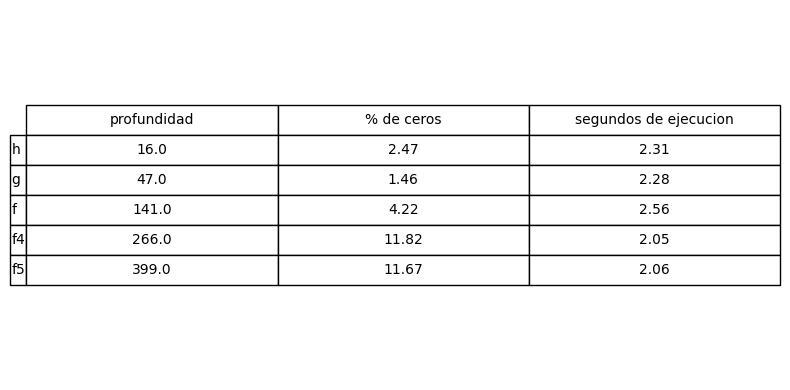

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# ejes ocultos
ax.axis('off')
ax.axis('tight')

# Crea tabla
table = ax.table(cellText=tabla.round(2).values,
                 colLabels=tabla.columns,
                 rowLabels=tabla.index,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
